# Практическая работа: Анализ датасета о качестве вина

## Введение

В данной работе мы проанализировали предложенный нам датасет по плану задания. Мы использовали различные библиотеки, изученные в курсе, а также sklearn для нормализации данных и применения метода главных компонент.

## Установка необходимых компонент

In [15]:
%pip install numpy pandas matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Импорт библиотек

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import warnings

## Настройка отображения изображений

In [17]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_style("whitegrid")

## Функция загрузки данных

Воспользуемся кодом из курса, по чтению данных из csv-файла при помощи pandas. Будем использовать try-catch конструкцию для грамотной обработки ошибки.

In [18]:
def load_data(filepath):
    """
    Загружает датасет из CSV файла с обработкой ошибок
    
    Parameters:
    -----------
    filepath : str
        Путь к CSV файлу
    
    Returns:
    --------
    pd.DataFrame or None
        Загруженные данные или None в случае ошибки
    """
    try:
        data = pd.read_csv(filepath)
        print(f"✓ Данные успешно загружены из {filepath}")
        print(f"Размер датасета: {data.shape[0]} строк, {data.shape[1]} столбцов")
        return data
    except FileNotFoundError:
        print(f"✗ Файл {filepath} не найден")
        return None
    except pd.errors.EmptyDataError:
        print(f"✗ Файл {filepath} пуст")
        return None
    except Exception as e:
        print(f"✗ Ошибка при загрузке данных: {e}")
        return None

## Функция преобразования нечисловых параметров

Данная функция принимает на вход датасет, вычленяет колонки с категориальными переменными и заполняет отсутствующие значения словом, сигнализирующем об отсутствии значения. Затем преобразовывает все категориальные столбцы в числовые.

In [19]:
def transform_categorical_data(data):
    """
    Преобразует категориальные переменные в числовые
    
    Процесс преобразования:
    1. Выявляет столбцы с типом 'object' (строковые)
    2. Заполняет пропущенные значения меткой 'Unknown'
    3. Применяет LabelEncoder для преобразования в числа
    
    Parameters:
    -----------
    data : pd.DataFrame
        Исходный датасет
    
    Returns:
    --------
    tuple
        (преобразованные_данные, словарь_энкодеров)
    """
    data_transformed = data.copy()
    label_encoders = {}
    
    # Находим все категориальные столбцы (тип 'object')
    categorical_columns = data_transformed.select_dtypes(include=['object']).columns
    print(f"Найдено категориальных столбцов: {len(categorical_columns)}")
    
    for column in categorical_columns:
        print(f"Обрабатываем столбец '{column}'...")
        
        # Создаем энкодер для каждого столбца
        label_encoders[column] = LabelEncoder()
        
        # Заполняем пропущенные значения
        # Это необходимо, так как LabelEncoder не работает с NaN
        data_transformed[column] = data_transformed[column].fillna('Unknown')
        
        # Применяем кодирование: строки -> числа
        data_transformed[column] = label_encoders[column].fit_transform(data_transformed[column])
        
        unique_values = label_encoders[column].classes_
        print(f"  Уникальные значения ({len(unique_values)}): {list(unique_values)}")
        
    return data_transformed, label_encoders

## Функция предобработки данных

Данная функция принимает на вход датасет, заполняет все пропущенные значения медианой, отделяет от остальных целевые переменные - качество и тип вина, а затем стандартизируем и нормируем переменные, то бишь выравниваем значение относительно нуля (делаем так, чтобы среднее значение равнялось нулю), а затем приводим все значения в диапазон [-1;1]

In [20]:
def preprocess_data(data):
    """
    Предобработка данных: обработка пропусков, центрирование и нормирование
    
    Этапы предобработки:
    1. Заполнение пропусков медианой (устойчива к выбросам)
    2. Разделение на признаки и целевые переменные
    3. Стандартизация признаков (среднее=0, дисперсия=1)
    
    Parameters:
    -----------
    data : pd.DataFrame
        Предварительно обработанный датасет
    
    Returns:
    --------
    tuple
        (стандартизированные_признаки, качество, тип_вина, скейлер)
    """
    processed_data = data.copy()
    print("Начинаем предобработку данных...")
    
    # 1. Обработка пропущенных значений
    numeric_columns = processed_data.select_dtypes(include=[np.number]).columns
    missing_before = processed_data[numeric_columns].isnull().sum().sum()
    
    if missing_before > 0:
        print(f"Найдено {missing_before} пропущенных значений, заполняем медианой...")
        imputer = SimpleImputer(strategy='median')
        processed_data[numeric_columns] = imputer.fit_transform(processed_data[numeric_columns])
        print("✓ Пропущенные значения заполнены")
    else:
        print("✓ Пропущенные значения не найдены")
    
    # 2. Извлечение целевых переменных
    target_quality = processed_data['quality'].copy()
    target_type = processed_data['type'].copy()
    
    # 3. Подготовка признаков (удаляем целевые переменные)
    features = processed_data.drop(['quality', 'type'], axis=1)
    print(f"Количество признаков для анализа: {features.shape[1]}")
    
    # 4. Стандартизация признаков
    # StandardScaler: (x - mean) / std_dev
    # Результат: среднее = 0, стандартное отклонение = 1
    scaler = StandardScaler()
    features_scaled = pd.DataFrame(
        scaler.fit_transform(features),
        columns=features.columns,
        index=features.index
    )
    
    print("✓ Стандартизация завершена")
    print(f"Среднее значение после стандартизации: {features_scaled.mean().mean():.6f}")
    print(f"Стандартное отклонение после стандартизации: {features_scaled.std().mean():.6f}")
    
    return features_scaled, target_quality, target_type, scaler

## Функция вычленения и отображения статистики датасета

Данная функция принимает на вход датасет, печает информацию о столбцах, занимаемой памяти и пропущенных значениях. 

In [21]:
def get_dataset_statistics(data):
    """
    Получает и выводит основные статистики по набору данных
    
    Parameters:
    -----------
    data : pd.DataFrame
        Исследуемый датасет
    """
    print("=" * 50)
    print("         СТАТИСТИКИ НАБОРА ДАННЫХ")
    print("=" * 50)
    
    print(f"\n📊 ОБЩАЯ ИНФОРМАЦИЯ:")
    print(f"   Размер данных: {data.shape[0]} строк × {data.shape[1]} столбцов")
    
    memory_usage = data.memory_usage(deep=True).sum()
    memory_kb = memory_usage / 1024
    print(f"   Объем данных: {memory_kb:.2f} КБ")
    
    print(f"\n📋 ТИПЫ ДАННЫХ:")
    for dtype, count in data.dtypes.value_counts().items():
        print(f"   {dtype}: {count} столбцов")
    
    print(f"\n❌ ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
    missing_data = data.isnull().sum()
    total_missing = missing_data.sum()
    
    if total_missing > 0:
        print(f"   Общее количество: {total_missing}")
        print(f"   По столбцам:")
        for col, missing in missing_data.items():
            if missing > 0:
                percentage = (missing / len(data)) * 100
                print(f"     {col}: {missing} ({percentage:.2f}%)")
    else:
        print("   Пропущенные значения отсутствуют ✓")
    
    print(f"\n🎯 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ 'quality':")
    quality_counts = data['quality'].value_counts().sort_index()
    print(f"   Диапазон: {data['quality'].min()} - {data['quality'].max()}")
    print(f"   Среднее: {data['quality'].mean():.2f}")
    print(f"   Распределение: {dict(quality_counts)}")
    
    print(f"\n🍷 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ 'type':")
    type_counts = data['type'].value_counts()
    print(f"   Распределение: {dict(type_counts)}")
    

## Функция применения метода главных компонент к матрице

Данная функция принимает на вход датасет, применяет к нему метод главных компонент(находится такой базис для исходнодных данных, что каждая последующая переменная содержит меньше информации по сравнению с предыдущей) и возвращает матрицу, содержащую столько столбцов, сколько было переданно в аргументе функции (по умолчанию 1)

In [22]:
def apply_pca(data, n_components=9):
    """
    Применяет метод главных компонент к данным
    
    МГК (PCA) выполняет:
    1. Вычисление ковариационной матрицы
    2. Нахождение собственных векторов и значений
    3. Проекцию данных на новые оси (главные компоненты)
    
    Главные компоненты упорядочены по убыванию объясненной дисперсии
    
    Parameters:
    -----------
    data : pd.DataFrame
        Стандартизированные данные
    n_components : int, optional
        Количество компонент (по умолчанию - все)
    
    Returns:
    --------
    tuple
        (результат_PCA, объект_PCA)
    """
    
    print(f"Применяем МГК с {n_components} компонентами...")
    
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(data)
    
    pca_df = pd.DataFrame(
        pca_result,
        columns=[f'PC{i+1}' for i in range(pca_result.shape[1])],
        index=data.index
    )
    
    print(f"✓ МГК применен успешно")
    print(f"Форма результата: {pca_df.shape}")
    
    return pca_df, pca

## Функция нахождения оптимального количества главных компонент

Данная функция принимает на вход датасет, а затем применяет к нему метод главных компонент пока процент объяснённой дисперсии не будет равен или больше заданного (по умолчанию 95%)

In [23]:
def find_optimal_components(data, variance_threshold=0.95):
    """
    Находит оптимальное количество главных компонент
    
    Критерий оптимальности: минимальное количество компонент,
    объясняющих заданный процент дисперсии данных
    
    Parameters:
    -----------
    data : pd.DataFrame
        Стандартизированные данные
    variance_threshold : float
        Пороговое значение объясненной дисперсии (0.95 = 95%)
    
    Returns:
    --------
    tuple
        (оптимальное_количество, массив_кумулятивной_дисперсии)
    """
    print(f"Ищем оптимальное количество компонент для {variance_threshold*100}% дисперсии...")
    
    pca_full = PCA()
    pca_full.fit(data)
    
    # Вычисляем кумулятивную объясненную дисперсию
    # explained_variance_ratio_ - доля дисперсии, объясненная каждой компонентой
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    
    optimal_components = np.argmax(cumulative_variance >= variance_threshold) + 1
    
    print(f"✓ Результаты анализа:")
    print(f"   Для {variance_threshold*100}% дисперсии нужно: {optimal_components} компонент")
    print(f"   Фактически объясняется: {cumulative_variance[optimal_components-1]*100:.2f}%")
    
    print(f"\n📊 Вклад первых компонент:")
    for i in range(min(5, len(pca_full.explained_variance_ratio_))):
        individual = pca_full.explained_variance_ratio_[i] * 100
        cumulative = cumulative_variance[i] * 100
        print(f"   PC{i+1}: {individual:.2f}% (кумулятивно: {cumulative:.2f}%)")
    
    return optimal_components, cumulative_variance

## Функция для построения двух графиков счетов для двух главных компонент

In [24]:
def plot_scores(pca_data, pca_model, target_quality=None, target_type=None):
    """
    Строит графики счетов для первых двух главных компонент
    для обеих целевых переменных
    
    График счетов показывает:
    - Как наблюдения располагаются в новом пространстве
    - Наличие кластеров и групп
    - Выбросы и аномальные значения
    - Связь с целевыми переменными
    
    Parameters:
    -----------
    pca_data : pd.DataFrame
        Результат применения PCA
    pca_model : PCA
        Обученная модель PCA
    target_quality : pd.Series, optional
        Качество вина
    target_type : pd.Series, optional
        Тип вина
    """
    _, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Получаем объясненную дисперсию для подписей осей
    pc1_var = pca_model.explained_variance_ratio_[0] * 100
    pc2_var = pca_model.explained_variance_ratio_[1] * 100
    
    # График 1: PC1 vs PC2, окрашенный по качеству вина
    if target_quality is not None:
        scatter1 = axes[0,0].scatter(pca_data['PC1'], pca_data['PC2'], 
                                   c=target_quality, cmap='RdYlBu_r', 
                                   alpha=0.7, s=50, edgecolors='black', linewidth=0.5)
        cbar1 = plt.colorbar(scatter1, ax=axes[0,0])
        cbar1.set_label('Качество вина', fontsize=12)
        
        # Добавляем статистику корреляции
        corr_pc1_quality = np.corrcoef(pca_data['PC1'], target_quality)[0,1]
        corr_pc2_quality = np.corrcoef(pca_data['PC2'], target_quality)[0,1]
        axes[0,0].text(0.02, 0.98, f'Корр. PC1-Quality: {corr_pc1_quality:.3f}\nКорр. PC2-Quality: {corr_pc2_quality:.3f}',
                      transform=axes[0,0].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axes[0,0].set_xlabel(f'PC1 ({pc1_var:.1f}% дисперсии)')
    axes[0,0].set_ylabel(f'PC2 ({pc2_var:.1f}% дисперсии)')
    axes[0,0].set_title('Счеты: PC1 vs PC2 (окраска по качеству)', fontsize=14, fontweight='bold')
    axes[0,0].grid(True, alpha=0.3)
    
    # График 2: PC1 vs PC2, окрашенный по типу вина
    if target_type is not None:
        unique_types = np.unique(target_type)
        colors = ['red', 'white'] if len(unique_types) == 2 else plt.cm.Set1(np.linspace(0, 1, len(unique_types)))
        
        for i, wine_type in enumerate(unique_types):
            mask = target_type == wine_type
            type_name = 'Красное' if wine_type == 0 else 'Белое' if wine_type == 1 else f'Тип {wine_type}'
            axes[0,1].scatter(pca_data.loc[mask, 'PC1'], pca_data.loc[mask, 'PC2'],
                            c=colors[i], label=type_name, alpha=0.7, s=50,
                            edgecolors='black', linewidth=0.5)
        
        axes[0,1].legend()
    
    axes[0,1].set_xlabel(f'PC1 ({pc1_var:.1f}% дисперсии)')
    axes[0,1].set_ylabel(f'PC2 ({pc2_var:.1f}% дисперсии)')
    axes[0,1].set_title('Счеты: PC1 vs PC2 (окраска по типу)', fontsize=14, fontweight='bold')
    axes[0,1].grid(True, alpha=0.3)
    
    # График 3: Распределение счетов PC1
    axes[1,0].hist(pca_data['PC1'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,0].set_xlabel(f'PC1 ({pc1_var:.1f}% дисперсии)')
    axes[1,0].set_ylabel('Частота')
    axes[1,0].set_title('Распределение счетов PC1', fontsize=14, fontweight='bold')
    axes[1,0].grid(True, alpha=0.3)
    
    # График 4: Распределение счетов PC2
    axes[1,1].hist(pca_data['PC2'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,1].set_xlabel(f'PC2 ({pc2_var:.1f}% дисперсии)')
    axes[1,1].set_ylabel('Частота')
    axes[1,1].set_title('Распределение счетов PC2', fontsize=14, fontweight='bold')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## График зависимости объяснённой дисперсии от количества главных компонент

In [25]:
def plot_variance_explained(cumulative_variance, optimal_components=None):
    """
    Строит график объясненной дисперсии
    
    Parameters:
    -----------
    cumulative_variance : array
        Массив кумулятивной объясненной дисперсии
    optimal_components : int, optional
        Оптимальное количество компонент для выделения на графике
    """
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Кумулятивная объясненная дисперсия
    components = range(1, len(cumulative_variance) + 1)
    ax1.plot(components, cumulative_variance * 100, 'bo-', linewidth=2, markersize=6)
    ax1.axhline(y=95, color='r', linestyle='--', alpha=0.7, label='95% порог')
    
    if optimal_components:
        ax1.axvline(x=optimal_components, color='g', linestyle='--', alpha=0.7, 
                   label=f'Оптимально: {optimal_components} компонент')
        ax1.plot(optimal_components, cumulative_variance[optimal_components-1] * 100, 
                'ro', markersize=10, markerfacecolor='red', markeredgecolor='darkred')
    
    ax1.set_xlabel('Количество главных компонент')
    ax1.set_ylabel('Кумулятивная объясненная дисперсия (%)')
    ax1.set_title('Кумулятивная объясненная дисперсия', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # График 2: Индивидуальная объясненная дисперсия
    individual_variance = np.diff(np.concatenate(([0], cumulative_variance))) * 100
    ax2.bar(components, individual_variance, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Главная компонента')
    ax2.set_ylabel('Объясненная дисперсия (%)')
    ax2.set_title('Индивидуальная объясненная дисперсия', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Графики и диаграммы нагрузов

In [26]:
def plot_loadings(pca_model, feature_names, title="График нагрузок (Loadings Plot)"):
    """
    Строит график нагрузок для первых главных компонент
    """
    _, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Нагрузки для PC1 и PC2
    loadings_pc1_pc2 = pca_model.components_[:2].T
    
    axes[0,0].scatter(loadings_pc1_pc2[:, 0], loadings_pc1_pc2[:, 1])
    for i, feature in enumerate(feature_names):
        axes[0,0].annotate(feature, (loadings_pc1_pc2[i, 0], loadings_pc1_pc2[i, 1]),
                         xytext=(5, 5), textcoords='offset points', fontsize=9)
    axes[0,0].set_xlabel(f'PC1 Loading')
    axes[0,0].set_ylabel(f'PC2 Loading')
    axes[0,0].set_title('Нагрузки: PC1 vs PC2')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[0,0].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    # Нагрузки для PC1 и PC3
    if pca_model.n_components_ > 2:
        loadings_pc1_pc3 = pca_model.components_[[0,2]].T
        
        axes[0,1].scatter(loadings_pc1_pc3[:, 0], loadings_pc1_pc3[:, 1])
        for i, feature in enumerate(feature_names):
            axes[0,1].annotate(feature, (loadings_pc1_pc3[i, 0], loadings_pc1_pc3[i, 1]),
                             xytext=(5, 5), textcoords='offset points', fontsize=9)
        axes[0,1].set_xlabel(f'PC1 Loading')
        axes[0,1].set_ylabel(f'PC3 Loading')
        axes[0,1].set_title('Нагрузки: PC1 vs PC3')
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[0,1].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    # Столбчатая диаграмма нагрузок PC1
    axes[1,0].bar(range(len(feature_names)), pca_model.components_[0])
    axes[1,0].set_xticks(range(len(feature_names)))
    axes[1,0].set_xticklabels(feature_names, rotation=45, ha='right')
    axes[1,0].set_title('Нагрузки первой главной компоненты (PC1)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Столбчатая диаграмма нагрузок PC2
    axes[1,1].bar(range(len(feature_names)), pca_model.components_[1])
    axes[1,1].set_xticks(range(len(feature_names)))
    axes[1,1].set_xticklabels(feature_names, rotation=45, ha='right')
    axes[1,1].set_title('Нагрузки второй главной компоненты (PC2)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Применение всех раннее описанных функций

🍷 НАЧИНАЕМ ПОЛНЫЙ АНАЛИЗ КАЧЕСТВА ВИНА 🍷

1️⃣ ЗАГРУЗКА ДАННЫХ
✓ Данные успешно загружены из winequalityN.csv
Размер датасета: 6497 строк, 13 столбцов

2️⃣ АНАЛИЗ ИСХОДНЫХ ДАННЫХ
         СТАТИСТИКИ НАБОРА ДАННЫХ

📊 ОБЩАЯ ИНФОРМАЦИЯ:
   Размер данных: 6497 строк × 13 столбцов
   Объем данных: 948.71 КБ

📋 ТИПЫ ДАННЫХ:
   float64: 11 столбцов
   object: 1 столбцов
   int64: 1 столбцов

❌ ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:
   Общее количество: 38
   По столбцам:
     fixed acidity: 10 (0.15%)
     volatile acidity: 8 (0.12%)
     citric acid: 3 (0.05%)
     residual sugar: 2 (0.03%)
     chlorides: 2 (0.03%)
     pH: 9 (0.14%)
     sulphates: 4 (0.06%)

🎯 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ 'quality':
   Диапазон: 3 - 9
   Среднее: 5.82
   Распределение: {3: 30, 4: 216, 5: 2138, 6: 2836, 7: 1079, 8: 193, 9: 5}

🍷 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ 'type':
   Распределение: {'white': 4898, 'red': 1599}

3️⃣ ПРЕОБРАЗОВАНИЕ ДАННЫХ
Найдено категориальных столбцов: 1
Обрабатываем столбец 'type'...
  Уникальные значения (2): ['red', 'white

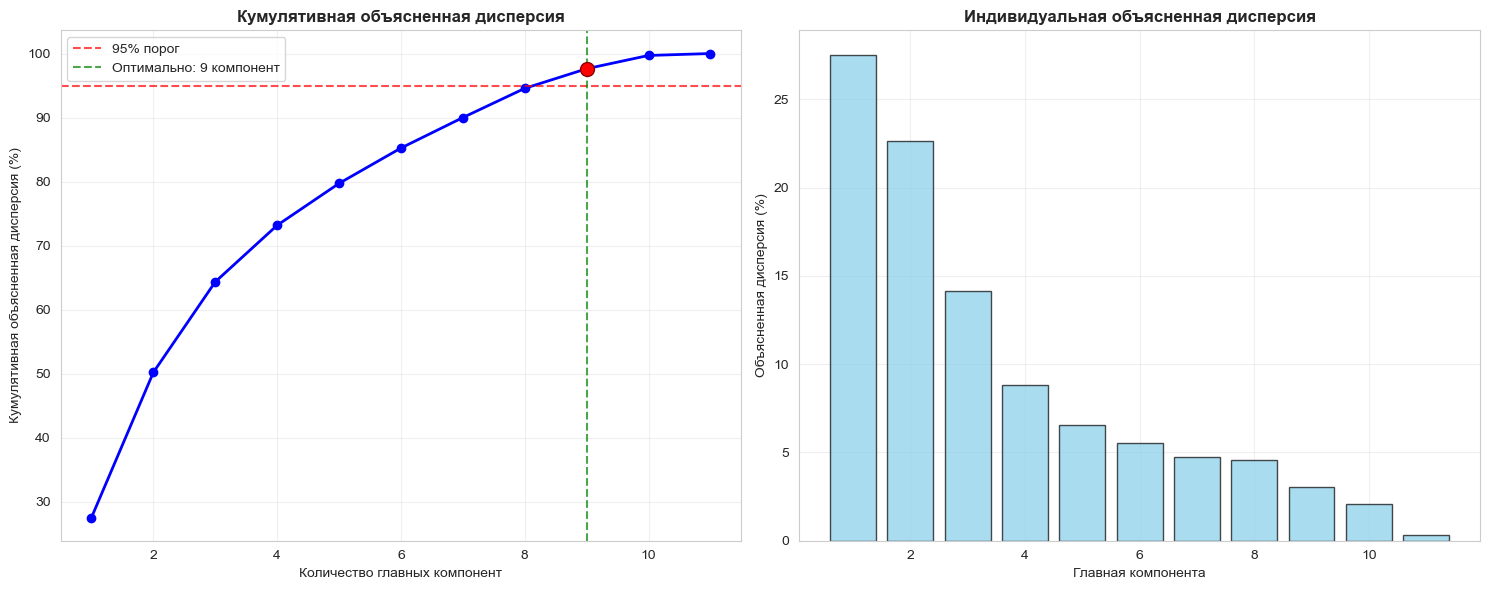

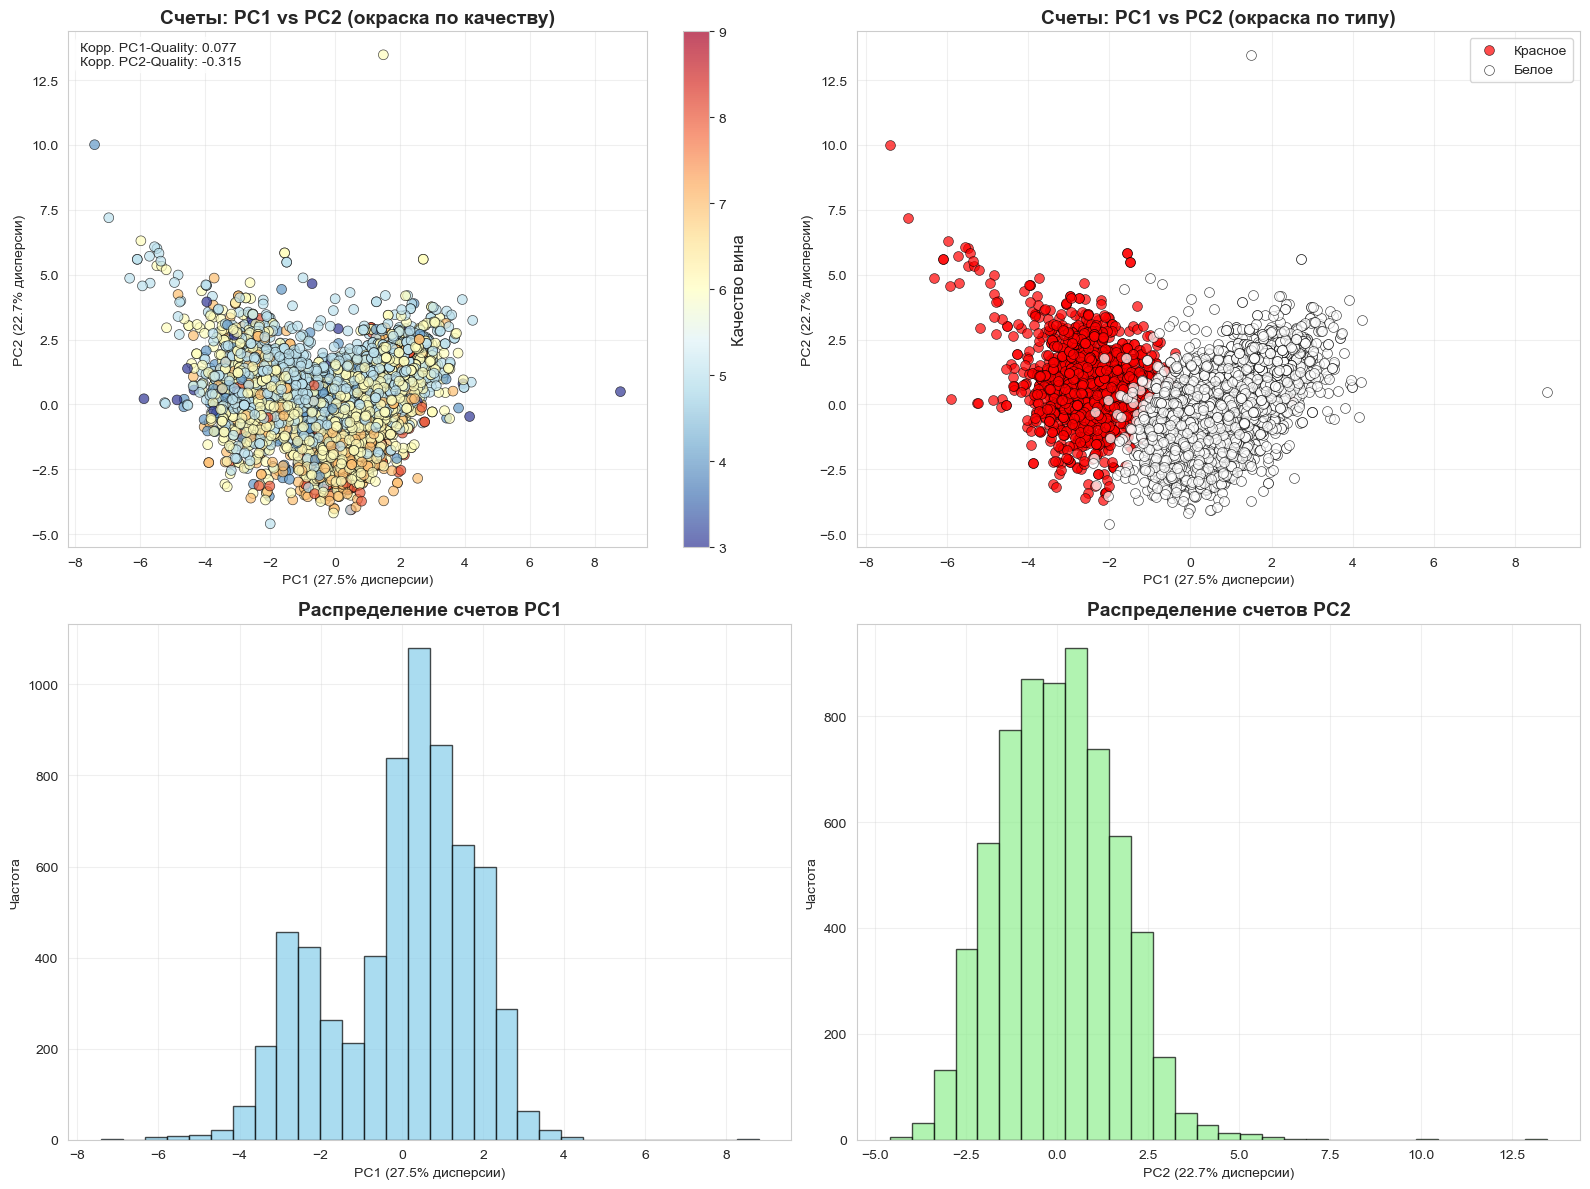

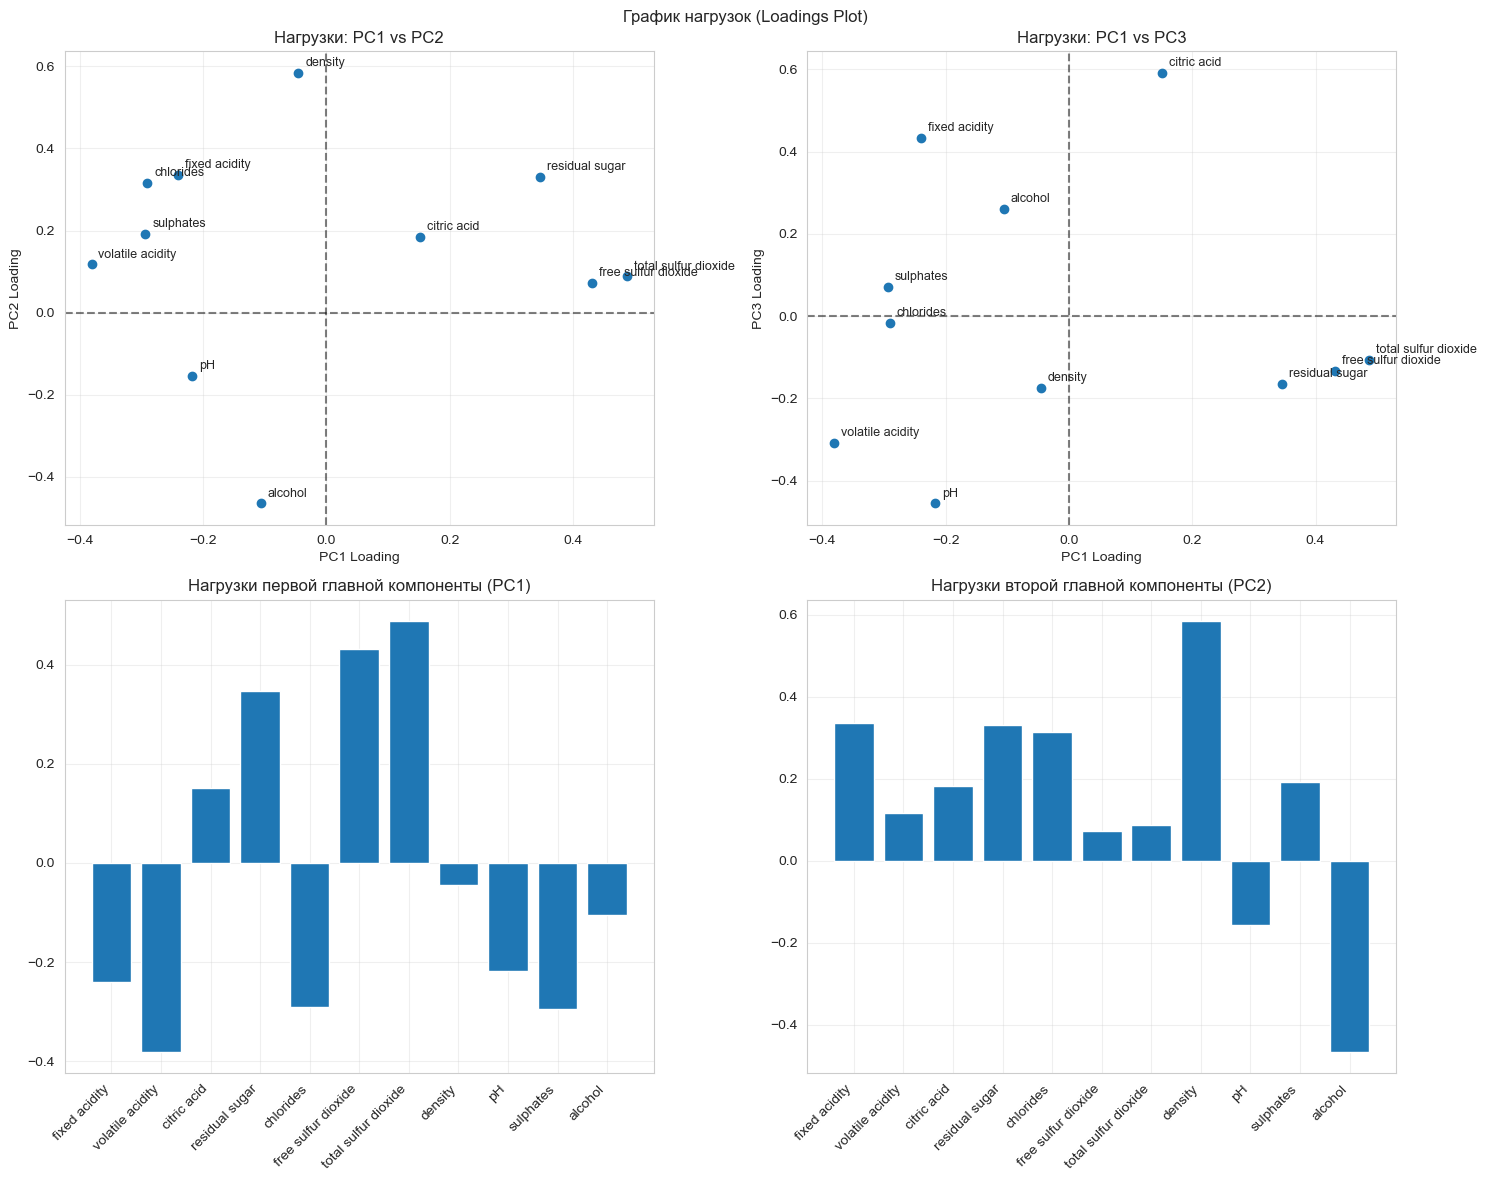


✅ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!


In [27]:
print("🍷 НАЧИНАЕМ ПОЛНЫЙ АНАЛИЗ КАЧЕСТВА ВИНА 🍷")
print("=" * 60)

filepath = "winequalityN.csv"

print("\n1️⃣ ЗАГРУЗКА ДАННЫХ")
data = load_data(filepath)

print("\n2️⃣ АНАЛИЗ ИСХОДНЫХ ДАННЫХ")
get_dataset_statistics(data)

print("\n3️⃣ ПРЕОБРАЗОВАНИЕ ДАННЫХ")
data_transformed, encoders = transform_categorical_data(data)

print("\n4️⃣ ПРЕДОБРАБОТКА ДАННЫХ")
features_scaled, target_quality, target_type, scaler = preprocess_data(data_transformed)

print("\n5️⃣ ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО КОЛИЧЕСТВА КОМПОНЕНТ")
optimal_n, cumulative_var = find_optimal_components(features_scaled, 0.95)

print("\n6️⃣ ПРИМЕНЕНИЕ МЕТОДА ГЛАВНЫХ КОМПОНЕНТ")
pca_data, pca_model = apply_pca(features_scaled, optimal_n)

print("\n7️⃣ ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
plot_variance_explained(cumulative_var, optimal_n)
plot_scores(pca_data, pca_model, target_quality, target_type)
plot_loadings(pca_model, features_scaled.columns.tolist())

print("\n✅ АНАЛИЗ ЗАВЕРШЕН УСПЕШНО!")
print("=" * 60)